In [17]:
import networkx as nx
import random
import xml.etree.cElementTree as et
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from networkx.algorithms import bipartite
import json
import random
from sklearn import metrics
from collections import deque
import pandas as pd

### Importing JSON File

In [18]:
file_data = json.load(open('./products_data.json'))
data = file_data['category_results']
attribute_data = json.load(open('./data.json', encoding='utf-8'))
asin_to_name = {}

for prd in data:
    asin_to_name[prd['asin']] = prd['title']

print(len(list(asin_to_name.keys())))

154


In [19]:
products = []
attributes = []
edges = []

attribute_keys = {}

for prd in data:
    products.append(prd['asin'])
    asin = prd['asin']
    # if attribute_data[asin]['product']['specifications'] is None:
    #     continue
    product_specs = attribute_data[asin]['product']['specifications']
    for spec in product_specs:
        attribute_name = spec['name']
        edges.append((asin, attribute_name))
        attribute_keys[spec['name']] = 1

attributes = list(attribute_keys.keys())
print("Number of products", len(products), sep='\n')
print("Number of attributes", len(attributes), sep='\n')
print("Number of edges", len(edges), sep='\n')


Number of products
154
Number of attributes
79
Number of edges
4534


#### Making nodes Unique by giving them to a numerical index

In [20]:
is_swapped = False
if len(attributes) < len(products):
  temp = products.copy()
  products = attributes.copy()
  attributes = temp.copy()
  is_swapped = True

original_products = products.copy()
original_attributes = attributes.copy()
PRODUCTS_MAP = {}
ATTRIBUTES_MAP = {}
EDGES_MAP = {}
offset = len(products)

for idx, x in enumerate(products):
  PRODUCTS_MAP[x] = idx
  products[idx] = idx

for idx, x in enumerate(attributes):
  ATTRIBUTES_MAP[x] = idx + offset
  attributes[idx] = idx + offset

for idx, x in enumerate(edges):
  if is_swapped:
    edges[idx] = (ATTRIBUTES_MAP[x[0]], PRODUCTS_MAP[x[1]])
  else:
    edges[idx] = (PRODUCTS_MAP[x[0]], ATTRIBUTES_MAP[x[1]])

print('SET 1: ', products)
print('SET 2: ', attributes)

SET 1:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78]
SET 2:  [79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 21

### Making a Bipartite Graph

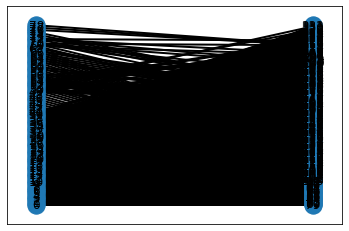

In [21]:
GRAPH = nx.Graph()

GRAPH.add_nodes_from(products, bipartite=0)
GRAPH.add_nodes_from(attributes, bipartite=1)
# top = nx.bipartite.sets(GRAPH)[0]
pos = nx.bipartite_layout(GRAPH, products)


GRAPH.add_edges_from(edges)
bipartite.is_bipartite(GRAPH)
nx.draw_networkx(GRAPH, pos = nx.drawing.layout.bipartite_layout(GRAPH, products), width = 2)

#### Adjacency Matrix

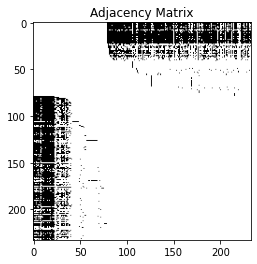

In [22]:
# Adjacency matrix
adj = nx.adjacency_matrix(GRAPH)
adj = adj.toarray()

U_NODES = products
V_NODES = attributes

# plot adjacency matrix
plt.title('Adjacency Matrix')
plt.imshow(adj, cmap='Greys')
plt.show()

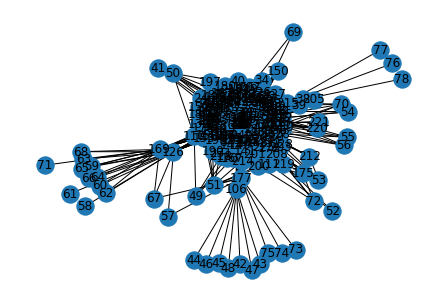

In [23]:
# plot graph visualisation
nx.draw(GRAPH, with_labels=True)

## TOP `n` ATTRIBUTES FOR EACH PRODUCT: -

In [24]:
TOP_N_PREDICTIONS = {}

def top_n_predictions(n, FINAL_RESULT):
    for pred in FINAL_RESULT:
        asin = list(pred.keys())[0][0]
        attribute = list(pred.keys())[0][1]
        similarity_value = pred[(asin, attribute)]
        if is_swapped:
            temp = asin
            asin = attribute
            attribute = temp

        if TOP_N_PREDICTIONS.get(asin) is None:
            TOP_N_PREDICTIONS[asin] = {'name': asin_to_name[asin], 'predicted_attributes': []}
        if len(TOP_N_PREDICTIONS[asin]['predicted_attributes']) == n:
            continue
        TOP_N_PREDICTIONS[asin]['predicted_attributes'].append({attribute: similarity_value})
    
    return TOP_N_PREDICTIONS

In [25]:
PREDICTIONS_ABOVE_K = {}

def top_predictions_above_threshold(k, FINAL_RESULT):
    for pred in FINAL_RESULT:
        asin = list(pred.keys())[0][0]
        attribute = list(pred.keys())[0][1]
        similarity_value = pred[(asin, attribute)]
        if is_swapped:
            temp = asin
            asin = attribute
            attribute = temp

        if PREDICTIONS_ABOVE_K.get(asin) is None:
            PREDICTIONS_ABOVE_K[asin] = {'name': asin_to_name[asin], 'predicted_attributes': []}
        if similarity_value < k:
            continue
        PREDICTIONS_ABOVE_K[asin]['predicted_attributes'].append({attribute: similarity_value})
    
    return PREDICTIONS_ABOVE_K

#### PLP FUNCTION: -

In [26]:
def PLP_ALGO2(GRAPH):
    global products
    global attributes
    # Construct the set of all patterns
    U_PROJ_PAIRS = []
    adj = nx.adjacency_matrix(GRAPH)
    adj = adj.toarray()

    for B in U_NODES:
        temp = [n for n in GRAPH.neighbors(B)]
        for x in temp:
            temp1 = [n for n in GRAPH.neighbors(x)]
            for C in temp1:
                if B != C and (C, B) not in U_PROJ_PAIRS and (B, C) not in U_PROJ_PAIRS:
                    U_PROJ_PAIRS.append((B, C))

    U_PROJ_PAIRS = set(U_PROJ_PAIRS)


    # adjList :)
    adjList = [[] for i in range(len(U_NODES) + len(V_NODES) + 300)]

    for node in U_NODES:
        for nbr in adj[node]:
            if not nbr:
                continue
            adjList[node].append(nbr)

    for node in V_NODES:
        for nbr in adj[node]:
            if not nbr:
                continue
            adjList[node].append(nbr)


    def dfs(depth, node, V, maxDepth):
        if V[node]:
            return 0
        qu = deque()
        qu.append(node)
        V[node] = True
        res = 1
        while not qu and depth <= maxDepth:
            sz = len(qu)

            for i in range(sz):
                front = qu.popleft()
                V[front] = 1
                for nbr in adjList[front]:
                    if V[nbr]:
                        continue
                    if depth%2 != 0:
                        res += 1
                    qu.append(nbr)

            depth += 1

        return res
                

    # Calculate the weight of each pattern
    weight = {}
    for pair in U_PROJ_PAIRS:
        A = pair[0]
        B = pair[1]
        
        deg_A = GRAPH.degree(A)
        deg_B = GRAPH.degree(B)
        
        neighbour_A = []
        neighbour_B = []
        for i in GRAPH.neighbors(A):
            neighbour_A.append(i)
        for i in GRAPH.neighbors(B):
            neighbour_B.append(i)

        neightbour_intersect = list(set(neighbour_A).intersection(neighbour_B))
        sum = 0
        maxi = 0
        V = [False for i in range(len(U_NODES) + len(V_NODES) + 300)]
        for intersect in neightbour_intersect:
            V[A] = True
            V[B] = True
            maxDepth = 3000
            denom = dfs(0, intersect, V, maxDepth) + 2
            sum = sum + 1/denom
            maxi = max(maxi, sum)
        sum = sum%(maxi+1)
        # print("sum: ", sum, sep="\n")
        weight[pair] = maxi * (2/(deg_A+deg_B))

    # print(weight, sep="\n")
    # print(len(weight))


    # U PROJECTED GRAPH

    U_PROJ_GRAPH = nx.projected_graph(GRAPH, U_NODES)

    # get adjacency matrix
    adj = nx.adjacency_matrix(U_PROJ_GRAPH)
    adj = adj.toarray()
    
    # # plot adjacency matrix
    # plt.title(' Adjacency Matrix')
    # plt.imshow(adj, cmap='Greys')
    # plt.show()

    # # plot graph visualisation
    # plt.figure(figsize=(10,10)) 
    # plt.title("Projected Graph")
    # nx.draw(U_PROJ_GRAPH, with_labels=True)
    # plt.show()


    # Calculate the connectivity of CNPs
    U_PROJ_GRAPH_NODES = U_PROJ_GRAPH.nodes()
    mat = {}
    linked_mat = {}

    for node in U_PROJ_GRAPH_NODES:
        for nbr in U_PROJ_GRAPH.neighbors(node):
            for nbrNode in GRAPH.neighbors(nbr):
                bipartiteNodeNeighbors = []

                for node_neighbour in GRAPH.neighbors(node):
                    bipartiteNodeNeighbors.append(node_neighbour)

                CNP = (node, nbrNode)
                if nbrNode not in bipartiteNodeNeighbors:

                    if mat.get(CNP) is None:
                        mat[CNP] = 0

                    if weight.get((node, nbr)) is None:
                        weight[(node, nbr)] = 0

                    mat[CNP] = mat.get(CNP) + weight.get((node, nbr))
                else:
                    if linked_mat.get(CNP) is None:
                        linked_mat[CNP] = 0

                    if weight.get((node, nbr)) is None:
                        weight[(node, nbr)] = 0

                    linked_mat[CNP] = linked_mat.get(CNP) + weight.get((node, nbr))



    keys = list(mat.keys())
    values = list(mat.values())
    sorted_value_index = np.argsort(values)
    sorted_mat = {keys[i]: values[i] for i in sorted_value_index}

    FINAL_RESULT = []
    RESULT_IMP = []
    sum = 0

    for pr in sorted_mat:
        temp = {}
        temp[(original_products[pr[0]], original_attributes[pr[1] - offset])] = sorted_mat[pr]
        RESULT_IMP.append((pr[0], pr[1], sorted_mat[pr]))
        FINAL_RESULT.append(temp)
        sum += sorted_mat[pr]

    FINAL_RESULT.reverse()
    RESULT_IMP.reverse()

    if is_swapped:
        temp = products.copy()
        products = attributes.copy()
        attributes = temp.copy()

    
    # print("total Predictions: ", FINAL_RESULT)
    # print("Top 10 predictions: ", FINAL_RESULT[:10])
    return [RESULT_IMP, FINAL_RESULT, mat, linked_mat]

In [27]:
def PLP_ALGO1(GRAPH):
    global products
    global attributes
    # Construct the set of all patterns
    U_PROJ_PAIRS = []

    for B in U_NODES:
        temp = [n for n in GRAPH.neighbors(B)]
        for x in temp:
            temp1 = [n for n in GRAPH.neighbors(x)]
            for C in temp1:
                if B != C and (C, B) not in U_PROJ_PAIRS and (B, C) not in U_PROJ_PAIRS:
                    U_PROJ_PAIRS.append((B, C))

    U_PROJ_PAIRS = set(U_PROJ_PAIRS)
        

    # Calculate the weight of each pattern
    weight = {}
    for pair in U_PROJ_PAIRS:
        A = pair[0]
        B = pair[1]
        
        deg_A = GRAPH.degree(A)
        deg_B = GRAPH.degree(B)
        
        neighbour_A = []
        neighbour_B = []
        for i in GRAPH.neighbors(A):
            neighbour_A.append(i)
        for i in GRAPH.neighbors(B):
            neighbour_B.append(i)

        neightbour_intersect = list(set(neighbour_A).intersection(neighbour_B))
        sum = 0
        for intersect in neightbour_intersect:
            sum += 1/(GRAPH.degree(intersect)+1)

        weight[pair] = sum * (2/(deg_A+deg_B))

    # print(weight, sep="\n")
    # print(len(weight))


    # U PROJECTED GRAPH

    U_PROJ_GRAPH = nx.projected_graph(GRAPH, U_NODES)

    # get adjacency matrix
    adj = nx.adjacency_matrix(U_PROJ_GRAPH)
    adj = adj.toarray()

    # plot adjacency matrix
    plt.title('Projected Graph Adjacency Matrix')
    plt.imshow(adj, cmap='Greys')
    plt.show()

    # # plot graph visualisation
    # plt.figure(figsize=(10,10)) 
    # plt.title("Projected Graph")
    # nx.draw(U_PROJ_GRAPH, with_labels=True)
    # plt.show()

    # Calculate the connectivity of CNPs
    U_PROJ_GRAPH_NODES = U_PROJ_GRAPH.nodes()
    mat = {}
    linked_mat = {}

    for node in U_PROJ_GRAPH_NODES:
        for nbr in U_PROJ_GRAPH.neighbors(node):
            for nbrNode in GRAPH.neighbors(nbr):
                bipartiteNodeNeighbors = []

                for node_neighbour in GRAPH.neighbors(node):
                    bipartiteNodeNeighbors.append(node_neighbour)

                CNP = (node, nbrNode)
                if nbrNode not in bipartiteNodeNeighbors:

                    if mat.get(CNP) is None:
                        mat[CNP] = 0

                    if weight.get((node, nbr)) is None:
                        weight[(node, nbr)] = 0

                    mat[CNP] = mat.get(CNP) + weight.get((node, nbr))
                else:
                    if linked_mat.get(CNP) is None:
                        linked_mat[CNP] = 0

                    if weight.get((node, nbr)) is None:
                        weight[(node, nbr)] = 0

                    linked_mat[CNP] = linked_mat.get(CNP) + weight.get((node, nbr))



    keys = list(mat.keys())
    values = list(mat.values())
    sorted_value_index = np.argsort(values)
    sorted_mat = {keys[i]: values[i] for i in sorted_value_index}

    FINAL_RESULT = []
    RESULT_IMP = []
    sum = 0

    for pr in sorted_mat:
        temp = {}
        temp[(original_products[pr[0]], original_attributes[pr[1] - offset])] = sorted_mat[pr]
        RESULT_IMP.append((pr[0], pr[1], sorted_mat[pr]))
        FINAL_RESULT.append(temp)
        sum += sorted_mat[pr]

    FINAL_RESULT.reverse()
    RESULT_IMP.reverse()

    if is_swapped:
        temp = products.copy()
        products = attributes.copy()
        attributes = temp.copy()

    
    # print("total Predictions: ", FINAL_RESULT)
    # print("Top 10 predictions: ", FINAL_RESULT[:10])
    return [RESULT_IMP, FINAL_RESULT, mat, linked_mat]

In [28]:
def evaluate_link_prediction(pred, train_G, test_G, k=10):
    # Create arrays of true labels (y_true) and predicted scores (y_score)
    y_true = [test_G.has_edge(p[0], p[1]) for p in pred]
    y_score = [p[2] for p in pred]

    # Compute AUC-ROC score
    auc_roc = metrics.roc_auc_score(y_true, y_score) 

    # Compute AUC-PRC score
    precision, recall, thresholds = metrics.precision_recall_curve(y_true, y_score)
    auc_prc = metrics.auc(recall, precision)

    # Compute precision at k
    y_pred = [1 if p[2] > thresholds[k] else 0 for p in pred]
    precision_at_k = metrics.precision_score(y_true, y_pred)

    # Compute F1 score
    f1_score = metrics.f1_score(y_true, y_pred)

    # Print evaluation metrics
    print("AUC-ROC score: {:.4f}".format(auc_roc))
    print("AUC-PRC score: {:.4f}".format(auc_prc))
    print("Precision at k = {}: {:.4f}".format(k, precision_at_k))
    print("F1 score: {:.4f}".format(f1_score))

    # Plot auc roc graph
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.set_xlabel('Recall')
    ax1.set_ylabel('Precision')
    ax1.plot(recall, precision)
    ax1.set_title("Precision-Recall Curve")
    # plt.title('Precision-Recall Curve')

    # Compute AUC-ROC score
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_score) 
    ax2.plot(fpr, tpr)
    ax2.set_title("ROC Curve, AUC = {:.2f}".format(auc_roc))
    plt.show()

    return auc_roc, auc_prc, precision_at_k, f1_score

In [29]:
def RUN(data1, data2, idx):
    # Remove 30% of the edges
    proportion_edges = 0.3
    # this is our test set
    edge_subset = random.sample(GRAPH.edges(), int(proportion_edges * GRAPH.number_of_edges()))
    # Create a copy of the graph and remove the edges
    G_train = GRAPH.copy()
    G_train.remove_edges_from(edge_subset)

    # adjacency matrix
    A_train = nx.adjacency_matrix(G_train)
    A_train = A_train.toarray()

    plt.figure(figsize=(10,10)) 
    plt.title("Train Graph")
    nx.draw(G_train, pos, with_labels=True)
    plt.show()

    """
    TEST
    """
    G_test = nx.Graph()
    G_test.add_edges_from(edge_subset)

    plt.figure(figsize=(10,10)) 
    plt.title("Test Graph")
    nx.draw(G_test, pos, with_labels=True)
    plt.show()


    G_pred = nx.Graph()
    [RESULT1, FINAL_RESULT1, mat, linked_mat] = PLP_ALGO1(G_train)
    [RESULT2, FINAL_RESULT2, mat, linked_mat] = PLP_ALGO2(G_train)
    print(FINAL_RESULT1 == FINAL_RESULT2, RESULT1 == RESULT2)

    G_pred.add_weighted_edges_from(RESULT1)
    G_pred.add_weighted_edges_from(RESULT2)

    print("for algo1: -", sep="\n")
    [auc_roc1, auc_prc1, precision_at_k1, f1_score1] = evaluate_link_prediction(RESULT1, G_train, G_test, 3)
    print("for algo2: -", sep="\n")
    [auc_roc2, auc_prc2, precision_at_k2, f1_score2] = evaluate_link_prediction(RESULT2, G_train, G_test, 3)
    
    data1["auc_roc"].append(auc_roc1 * 100)
    data1["auc_prc"].append(auc_prc1 * 100)
    
    data2["auc_roc"].append(auc_roc2 * 100)
    data2["auc_prc"].append(auc_prc2 * 100)
    
    
    TOP_N_PREDICTIONS1 = top_n_predictions(5, FINAL_RESULT1)
    TOP_N_PREDICTIONS2 = top_n_predictions(5, FINAL_RESULT2)

    file_name1 = "results_predictions_algo1/result{}.json".format(idx)
    f = open(file_name1, "w")
    
    # Serializing json  
    TOP_N_PREDICTIONS1 = json.dumps(TOP_N_PREDICTIONS1, indent = 4) 
    f.write(TOP_N_PREDICTIONS1)

    file_name2 = "results_predictions_algo2/result{}.json".format(idx)
    f = open(file_name2, "w")
    
    # Serializing json  
    TOP_N_PREDICTIONS2 = json.dumps(TOP_N_PREDICTIONS2, indent = 4) 
    f.write(TOP_N_PREDICTIONS2)



    # PREDICTIONS_ABOVE_K1 = top_predictions_above_threshold(0.6, FINAL_RESULT1)
    # PREDICTIONS_ABOVE_K2 = top_predictions_above_threshold(0.6, FINAL_RESULT2)

    # file_name1 = "results_predictions_k_algo1/result{}.json".format(idx)
    # f = open(file_name1, "w")
    
    # # Serializing json  
    # PREDICTIONS_ABOVE_K1 = json.dumps(PREDICTIONS_ABOVE_K1, indent = 4) 
    # f.write(PREDICTIONS_ABOVE_K1)

    # file_name2 = "results_predictions_k_algo2/result{}.json".format(idx)
    # f = open(file_name2, "w")
    
    # # Serializing json  
    # PREDICTIONS_ABOVE_K2 = json.dumps(PREDICTIONS_ABOVE_K2, indent = 4) 
    # f.write(PREDICTIONS_ABOVE_K2)

    # # visualise adjacency matrix
    # Apred = nx.adjacency_matrix(G_pred)
    # Apred = Apred.toarray()
    # plt.imshow(Apredcmaps, cmap='Greys')
    # plt.show()


    # plt.figure(figsize=(10,10)) 
    # plt.title("Prediction Graph")
    # nx.draw(G_pred, pos, with_labels=True)
    # plt.show()

1


C:\Users\Siddharth\AppData\Local\Temp\ipykernel_1792\498283674.py:5: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  edge_subset = random.sample(GRAPH.edges(), int(proportion_edges * GRAPH.number_of_edges()))


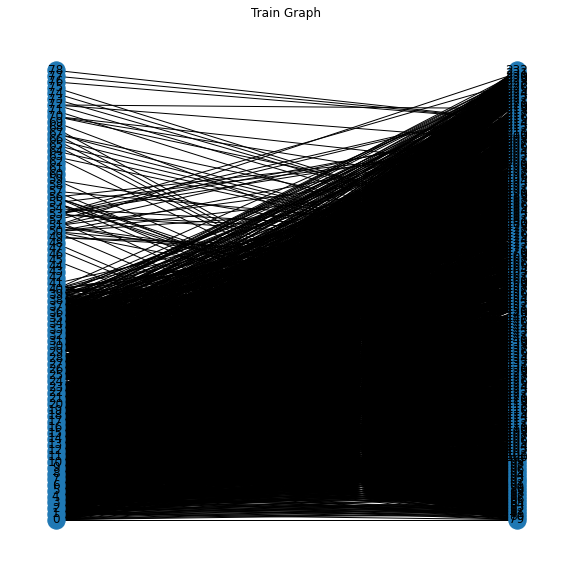

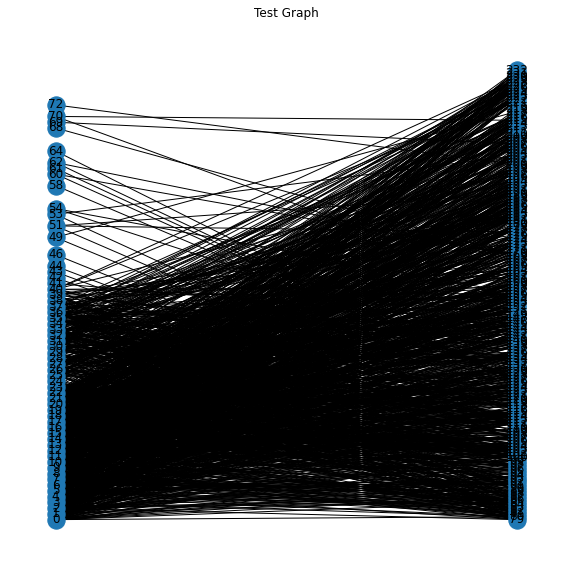

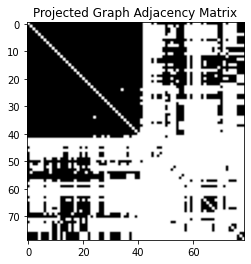

False False
for algo1: -
AUC-ROC score: 0.9255
AUC-PRC score: 0.7334
Precision at k = 3: 0.4379
F1 score: 0.5991


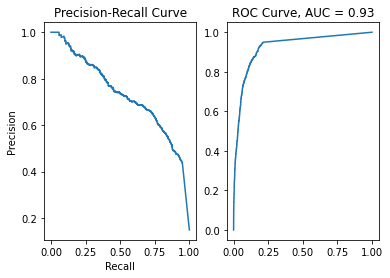

for algo2: -
AUC-ROC score: 0.9248
AUC-PRC score: 0.7259
Precision at k = 3: 0.4390
F1 score: 0.6002


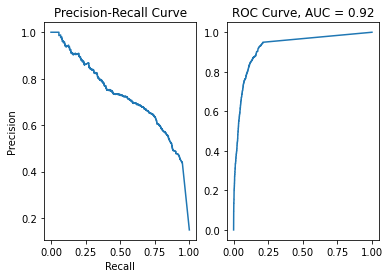

----------------------------------------END----------------------------------------

2


C:\Users\Siddharth\AppData\Local\Temp\ipykernel_1792\498283674.py:5: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  edge_subset = random.sample(GRAPH.edges(), int(proportion_edges * GRAPH.number_of_edges()))


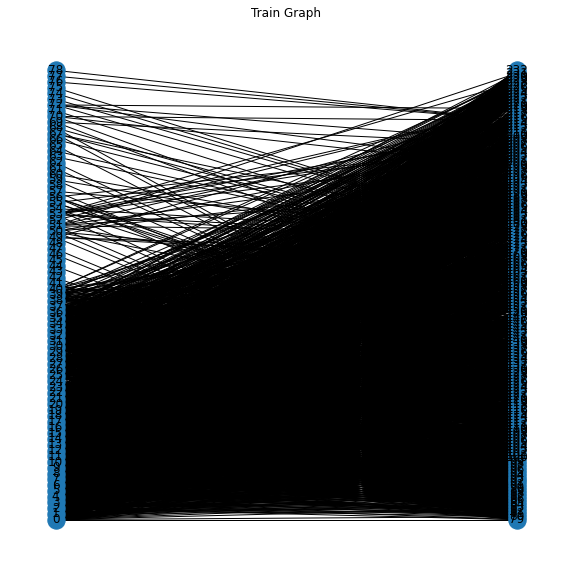

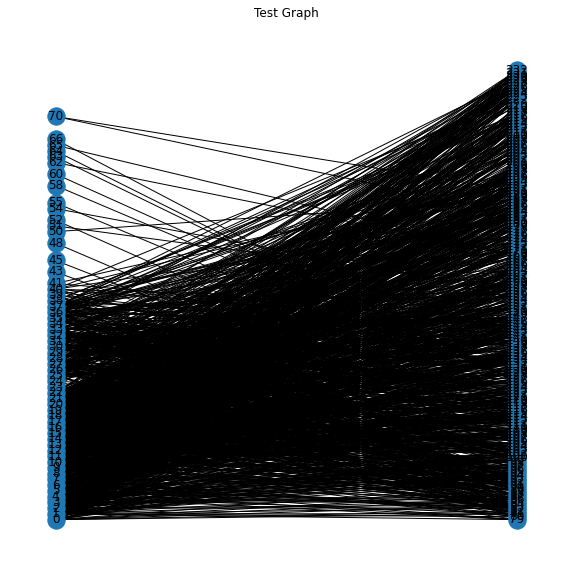

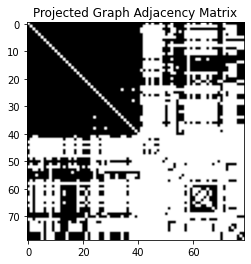

False False
for algo1: -
AUC-ROC score: 0.9274
AUC-PRC score: 0.7335
Precision at k = 3: 0.4320
F1 score: 0.5927


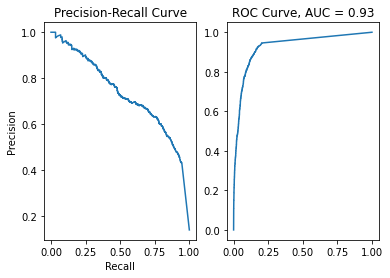

for algo2: -
AUC-ROC score: 0.9266
AUC-PRC score: 0.7254
Precision at k = 3: 0.4324
F1 score: 0.5931


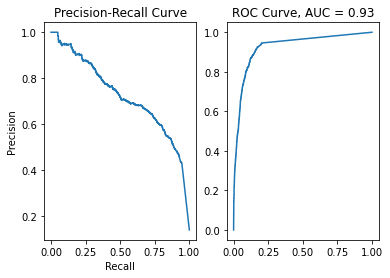

----------------------------------------END----------------------------------------

3


C:\Users\Siddharth\AppData\Local\Temp\ipykernel_1792\498283674.py:5: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  edge_subset = random.sample(GRAPH.edges(), int(proportion_edges * GRAPH.number_of_edges()))


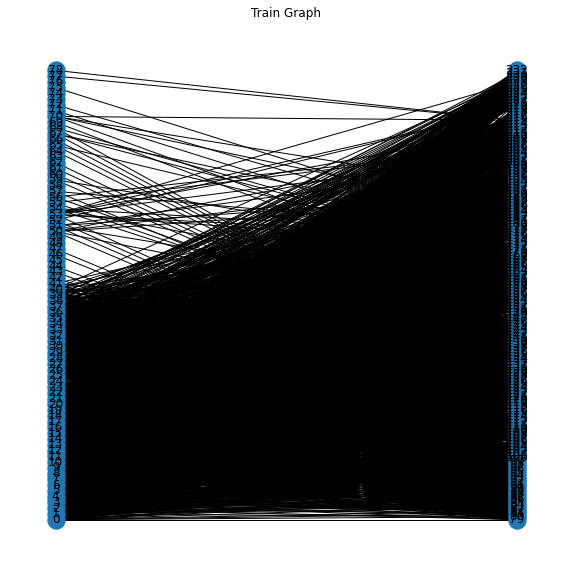

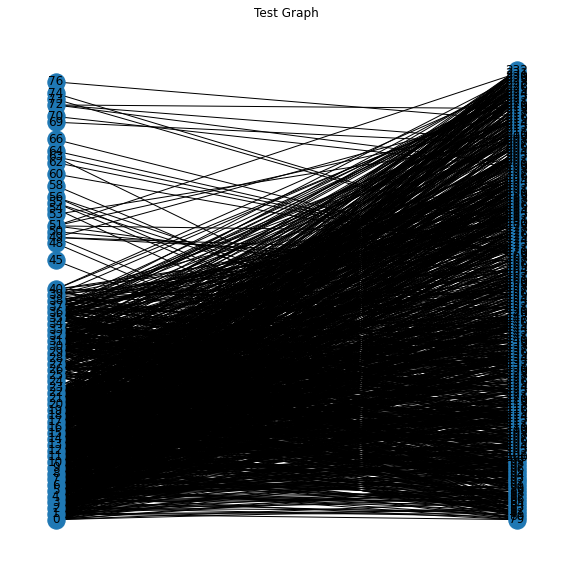

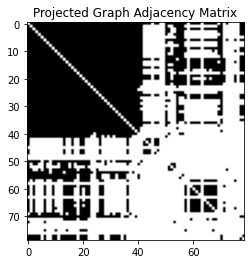

False False
for algo1: -
AUC-ROC score: 0.9160
AUC-PRC score: 0.7308
Precision at k = 3: 0.4285
F1 score: 0.5868


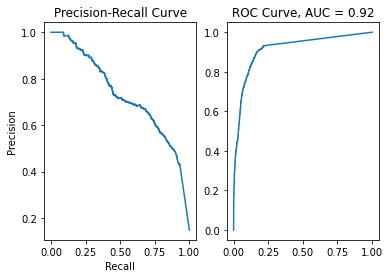

for algo2: -
AUC-ROC score: 0.9152
AUC-PRC score: 0.7230
Precision at k = 3: 0.4276
F1 score: 0.5859


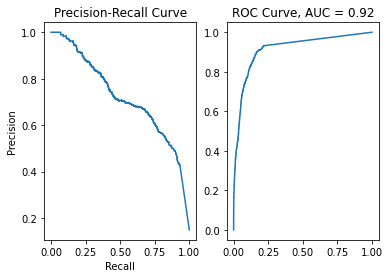

----------------------------------------END----------------------------------------



In [30]:
# df1 = pd.DataFrame({'auc_roc': [], 'auc_prc': []})
# df2 = pd.DataFrame({'auc_roc': [], 'auc_prc': []})
data1 = {'auc_roc': [], 'auc_prc': []}
data2 = {'auc_roc': [], 'auc_prc': []}
for i in range(3):
    print(i+1, sep="\n")
    RUN(data1, data2, i+1)
    print("----------------------------------------END----------------------------------------\n")

df1 = pd.DataFrame(data1)
df2 = pd.DataFrame(data2)

In [31]:
df1


,auc_roc,auc_prc
0,92.545552,73.336226
1,92.738792,73.353081
2,91.604323,73.083322


In [32]:
df2

,auc_roc,auc_prc
0,92.478357,72.588558
1,92.655714,72.541638
2,91.524484,72.299420
